## Costs



### Preface



There are a few modules you may need to install (but avoid this if you can; you may need to restart your kernel afterwards):



In [1]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

We import critical objects from `example_nutrition.py`, avoiding the need to do so in this notebook.  These are for Uganda:



Index(['Avocado', 'Beef', 'Biscuits', 'Bread', 'Chicken', 'Cooking Oil',
       'Cucumber', 'Eggs', 'Pork', 'Rice', 'Salt', 'Sugar', 'Tea', 'Yoghurt'],
      dtype='object', name='j')


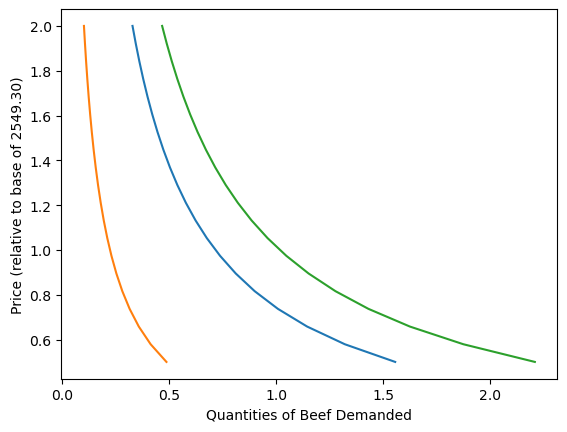

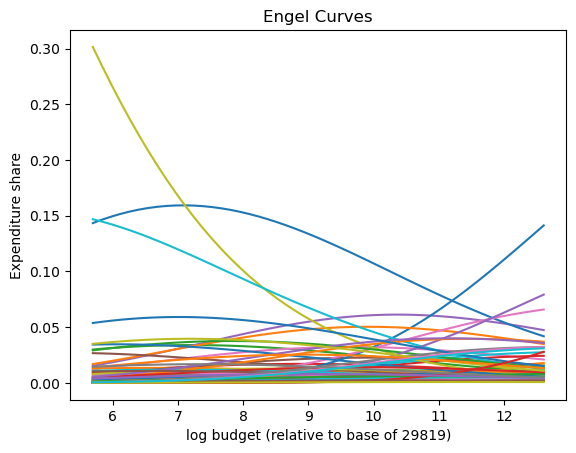

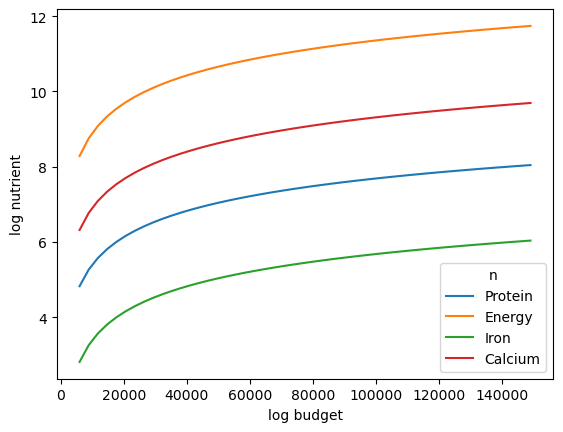

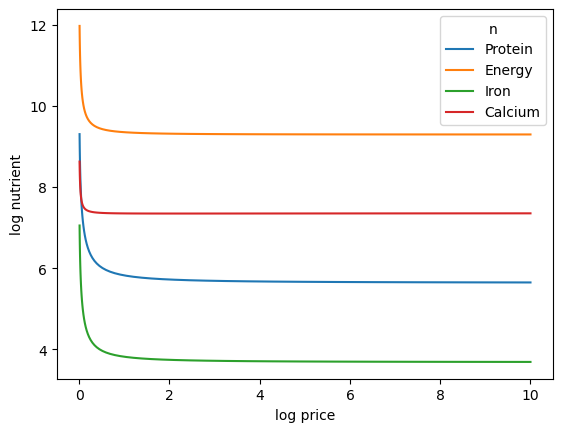

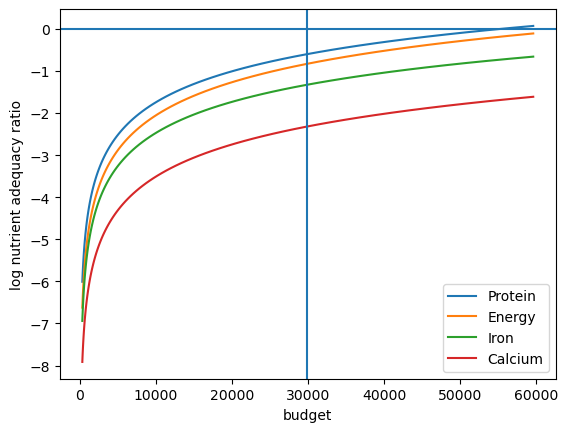

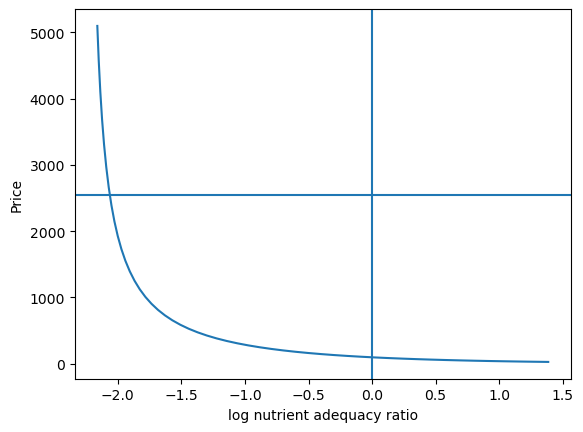

In [5]:
from example_nutrition import r as mlw
from example_nutrition import rdi, nutrient_demand

### Ceteris Paribus



We begin by setting up some benchmarks for prices and budgets, so
    the things we don&rsquo;t want to change we can hold fixed.



In [7]:
from example_nutrition import pbar, my_prices

#### Budgets



Get food budget for all households, then find median budget:



In [8]:
import numpy as np

xhat = mlw.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
x0 = xbar.quantile(0.5)  # Household at 0.5 quantile is median

### Simple Policy Experiments: Changing Prices



If price of a good increases/decreases, what&rsquo;s the cost to the
household?  Ask a related question: If a price $p_1$ increases, how
much *income* do we need to give to the household to make it just as
well off as it was at the old prices?

Summarize this as the  *compensating variation* associated with the
price change.

![img](./compensating_variation.png)

Compensating Variation can also be measured as the (change in the)
area under the **Hicksian** (or **compensated**) demand curve:

![img](./compensating_variation_newexpenditure.png).



#### Marshallian vs. Hicksian Demand Curves



Let&rsquo;s look at Marshallian & Hicksian demands&#x2014;one way of thinking
about the Hicksian (compensated) curves is that they  eliminate the
income effect associated with changing prices.



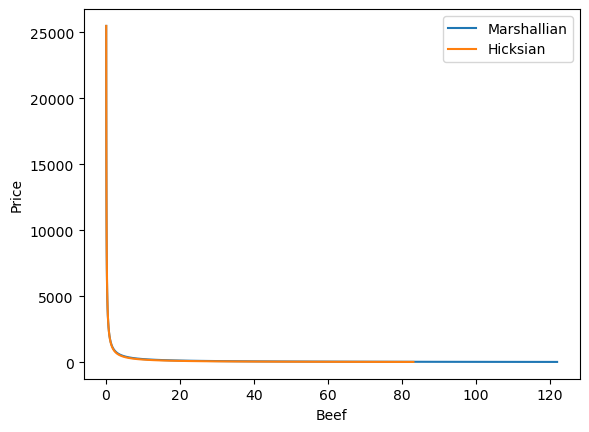

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

my_j = 'Beef'  # Interesting Ugandan staple

P = np.geomspace(.01,10,50)*pbar[my_j]

# Utility of median household, given prices
U0 = mlw.indirect_utility(x0,pbar)

plt.plot([mlw.demands(x0,my_prices(my_j,p0))[my_j] for p0 in P],P)
plt.plot([mlw.demands(U0,my_prices(my_j,p0),type="Hicksian")[my_j] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_j)
plt.legend(("Marshallian","Hicksian"))

#### Welfare measures



In [11]:
def compensating_variation(U0,p0,p1):
    x0 = mlw.expenditure(U0,p0)
    x1 = mlw.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = mlw.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian')

#### Price Changes, Revenue, and Compensating Variation



Examine effects of price changes on revenue (if price change due to a
tax or subsidy) and compensating variation.



In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,pbar,my_prices(my_j,p0)) for p0 in P])
ax1.set_xlabel(f"Price of {my_j}")
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,pbar,my_prices(my_j,p0),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(pbar.loc[my_j])

#### Deadweight Loss



Differences between revenue and compensating variation is deadweight-loss:



In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,pbar,my_prices(my_j,p0)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_j)
ax1.set_ylabel("Deadweight Loss")